In [1]:
import numpy as np
import torch
import math
import torch.nn as nn

In [11]:
source_ids = torch.Tensor([1, 2, 3, 4]).unsqueeze(0)

In [12]:
torch.rand(4, 4)

tensor([[0.5363, 0.2272, 0.1860, 0.7315],
        [0.9086, 0.0630, 0.2553, 0.2518],
        [0.6234, 0.1942, 0.3476, 0.9220],
        [0.9285, 0.5258, 0.4071, 0.4012]])

In [13]:
torch.rand(4, 4) + (source_ids != 3).unsqueeze(-2).unsqueeze(1)

tensor([[[[1.4552, 1.4814, 0.6402, 1.5917],
          [1.3358, 1.9475, 0.4557, 1.5919],
          [1.6448, 1.8847, 0.6967, 1.7685],
          [1.7142, 1.5051, 0.3452, 1.1180]]]])

In [2]:
embedding_dim = 5
vocab_size = 20

In [3]:
embedding = nn.Embedding(vocab_size, embedding_dim)

In [76]:
token_id = torch.tensor([1, 2, 3])

In [72]:
token_id

tensor(4)

In [77]:
embedded_vector = embedding(token_id)

In [78]:
embedded_vector

tensor([[ 1.44, -1.25,  1.26,  1.34,  0.34],
        [ 0.09, -2.11,  0.19, -0.34, -1.01],
        [-0.86, -0.27,  0.41, -0.28,  0.80]], grad_fn=<EmbeddingBackward0>)

In [9]:
embedded_vector.shape

torch.Size([5])

# 1. Thực hành Self Attention

- Cơ chế self attention đề cập đến việc các từ trong câu sẽ chú ý đến các từ khác nào trong câu

In [80]:
# Đầu tiên, chúng ta có 1 câu đầu vào với độ dài là L 
# và với mỗi từ trong câu được embedding thành vector có độ dài là d_k
L, embedding_dim = 4, 8

- Self attention chứa 3 thành phần
    + Query: Biểu thị từ đang tìm kiếm
    + Key: Biểu thị những có thể phù hợp
    + Value: Biểu thị từ thực sự cần

In [81]:
# Khởi tạo random 3 vector là query, key, value
q = torch.rand(L, embedding_dim)
k = torch.rand(L, embedding_dim)
v = torch.rand(L, embedding_dim)

print("q:\n", q)
print("k:\n", k)
print("v:\n", v)

q:
 tensor([[0.69, 0.46, 0.01, 0.72, 0.47, 0.76, 0.82, 0.81],
        [0.72, 0.51, 0.18, 0.55, 0.20, 0.25, 0.86, 0.18],
        [1.00, 0.25, 0.35, 0.97, 0.37, 0.45, 0.63, 0.05],
        [0.08, 0.48, 0.54, 0.94, 0.86, 0.77, 0.37, 0.23]])
k:
 tensor([[0.95, 0.55, 0.06, 0.28, 0.90, 0.92, 0.13, 0.03],
        [0.05, 0.36, 0.11, 0.98, 0.64, 0.23, 0.71, 0.47],
        [0.63, 0.71, 0.84, 0.81, 0.44, 0.88, 0.10, 0.60],
        [0.67, 0.51, 0.34, 0.69, 0.20, 0.09, 0.93, 0.29]])
v:
 tensor([[0.91, 0.53, 0.33, 0.86, 0.07, 0.85, 0.04, 0.45],
        [0.13, 0.41, 0.34, 0.32, 0.33, 0.93, 0.23, 0.19],
        [0.11, 0.37, 0.32, 0.70, 0.74, 0.07, 0.46, 0.63],
        [0.62, 0.94, 0.61, 0.60, 0.16, 0.11, 0.35, 0.58]])


In [82]:
q.size()

torch.Size([4, 8])

In [84]:
k.transpose(0,1).size()

torch.Size([8, 4])

- Công thức của self-attention với M là mask

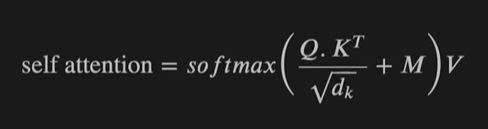

In [85]:
torch.matmul(q, k.transpose(0,1))

tensor([[2.36, 2.36, 2.80, 2.36],
        [1.66, 1.67, 1.93, 2.10],
        [2.21, 1.95, 2.55, 2.30],
        [2.16, 2.27, 2.83, 1.79]])

- Lý do cho việc chia cho căn bận 2 của d_k là vì
    + Giảm thiệu phương sai ở attention score
    + Đưa các giá trị về cùng 1 phạm vi
    + Nếu không chia thì phương sai của attention score sẽ lớn hơn rất nhiều so với phương sai của query và key

In [86]:
q.var(), k.var(), torch.matmul(q, k.transpose(0,1)).var()

(tensor(0.08), tensor(0.10), tensor(0.12))

In [87]:
attention_score = torch.matmul(q, k.transpose(0,1)) / np.sqrt(embedding_dim)
attention_score

tensor([[0.84, 0.83, 0.99, 0.84],
        [0.59, 0.59, 0.68, 0.74],
        [0.78, 0.69, 0.90, 0.81],
        [0.76, 0.80, 1.00, 0.63]])

In [89]:
F.softmax(attention_score)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13096\2080695832.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(attention_score)


tensor([[0.24, 0.24, 0.28, 0.24],
        [0.23, 0.23, 0.26, 0.27],
        [0.25, 0.22, 0.28, 0.25],
        [0.24, 0.25, 0.30, 0.21]])

In [14]:
q.var(), k.var(), attention_score.var()

(tensor(0.0778), tensor(0.0766), tensor(0.0691))

### Masking
- Ở tầng encoder thì được sử dụng để chỉ ra phần nào là token phần nào là padding
- Ở tầng decoder thì được sử dụng để tránh trong việc lấy được những thông tin ngữ cảnh từ những từ trong tương lai đổi với từ đang được xét, mask của tầng decoder được biểu thị bởi ma trận tam giác dưới

In [90]:
mask = torch.tril(torch.ones((L, L)))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [92]:
attention_score = attention_score.masked_fill(mask == 0, -1e9) + mask

In [102]:
attention_score

tensor([[ 1.84e+00, -1.00e+09, -1.00e+09, -1.00e+09],
        [ 1.59e+00,  1.59e+00, -1.00e+09, -1.00e+09],
        [ 1.78e+00,  1.69e+00,  1.90e+00, -1.00e+09],
        [ 1.76e+00,  1.80e+00,  2.00e+00,  1.63e+00]])

In [103]:
attention_score = torch.softmax(attention_score, dim=-1)

In [104]:
attention_score

tensor([[1.00, 0.00, 0.00, 0.00],
        [0.50, 0.50, 0.00, 0.00],
        [0.33, 0.30, 0.37, 0.00],
        [0.24, 0.25, 0.30, 0.21]])

- output của self-attention

In [105]:
output = torch.matmul(attention_score, v)

In [106]:
output

tensor([[0.91, 0.53, 0.33, 0.86, 0.07, 0.85, 0.04, 0.45],
        [0.52, 0.47, 0.34, 0.59, 0.20, 0.89, 0.14, 0.32],
        [0.38, 0.44, 0.33, 0.64, 0.40, 0.58, 0.25, 0.44],
        [0.41, 0.54, 0.39, 0.62, 0.36, 0.48, 0.28, 0.47]])

In [28]:
def scaled_dot_product_attention(q, k, v, mask=None):
    d_k = q.size(-1)
    scaled = torch.matmul(q, k.transpose(0, 1) / np.sqrt(d_k))
    
    if mask is not None:
        scaled = scaled + mask
    
    attention_score = torch.softmax(scaled, dim=-1)
    out = torch.matmul(attention_score, v)
    
    return out

# 2. Thực hành với Multi-Head Attention

- Multi-head attention bản chất là nhiều lớp self-attention
- Thay vì attention trên toàn bộ vector thì có thể chia vector đó thành nhiều head và attention trên từng head đó và concat lại với nhau

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4 # Độ dài của chuỗi đầu vào tầng encoder
batch_size = 1
input_dim = 512 # 1 từ trong chuỗi được embedding thành 1 vector có 512 chiều
output_dim = 512 # Số chiều của vector đầu ra

# Khởi tạo 1 vector ngẫu nhiên là biểu diễn embedding của 1 câu
x = torch.randn( (batch_size, sequence_length, input_dim) )
x.size()

torch.Size([1, 4, 512])

In [4]:
x[0]

tensor([[ 0.4024, -1.2401,  0.0098,  ...,  0.4648, -1.6585,  0.9141],
        [-0.0692,  1.1935, -1.3819,  ..., -0.9205, -0.1902, -1.7503],
        [-2.1112, -1.6602, -1.8278,  ..., -1.0586, -0.0120,  2.2327],
        [-0.4356,  1.0536, -0.2285,  ...,  1.3831,  0.6429, -0.8011]])

- Khởi tạo các layer để chiếu x qua thành các vector q, k ,v

In [5]:
q_layer = nn.Linear(input_dim, output_dim)
k_layer = nn.Linear(input_dim, output_dim)
v_layer = nn.Linear(input_dim, output_dim)

- input_dim là kích thước đầu vào
- output_dim là kích thước đầu ra

In [12]:
q = q_layer(x)
k = k_layer(x)
v = v_layer(x)

In [14]:
q.size()

torch.Size([1, 4, 512])

In [15]:
# Khởi tạo head = 8
n_heads = 8
head_dim = output_dim // n_heads
q = q.view(batch_size, sequence_length, n_heads, head_dim)
k = k.view(batch_size, sequence_length, n_heads, head_dim)
v = v.view(batch_size, sequence_length, n_heads, head_dim)

q.size()

torch.Size([1, 4, 8, 64])

- Chuyển vị ma trận để tính attention cho từng head

In [16]:
q = q.transpose(1, 2)
k = k.transpose(1, 2)
v = v.transpose(1, 2)

In [17]:
q.size()

torch.Size([1, 8, 4, 64])

- Sau đó tính attention cho từng head như ở phần 1

In [18]:
d_k = head_dim
scaled = torch.matmul(q, k.transpose(2, 3)) / np.sqrt(d_k)
scaled.size()

torch.Size([1, 8, 4, 4])

- Hiển thị giá trị của head đầu tiên sau khi tính q * k.T

In [37]:
scaled[0][0]

tensor([[ 0.3785,  0.1567,  0.1779,  0.1302],
        [-0.2119,  0.0366, -0.0393,  0.3002],
        [-0.2933,  0.1560,  0.0907,  0.3653],
        [ 0.1521, -0.5995,  0.7827, -0.4278]], grad_fn=<SelectBackward0>)

In [19]:
scaled[0][1]

tensor([[ 0.0745,  0.1385,  0.2918,  0.0265],
        [-0.2789,  0.3331, -0.0090, -0.2281],
        [-0.2510,  0.6174, -0.0053,  0.1044],
        [ 0.3978, -0.0713, -0.4482,  0.4787]], grad_fn=<SelectBackward0>)

In [20]:
# Khởi tạo mask
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)

# Hiển thị mask cho từng head
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [21]:
(scaled + mask)[0][0]

tensor([[ 0.6722,    -inf,    -inf,    -inf],
        [ 0.3378, -0.0946,    -inf,    -inf],
        [ 0.0768,  0.0032, -0.5071,    -inf],
        [-0.1145,  0.2359, -0.4039,  0.2241]], grad_fn=<SelectBackward0>)

In [22]:
attention_score = scaled+mask

In [23]:
# Dùng softmax để đưa về phân phối xác suất
attention_score = F.softmax(attention_score, dim=-1)

In [24]:
attention_score[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6064, 0.3936, 0.0000, 0.0000],
        [0.4021, 0.3736, 0.2243, 0.0000],
        [0.2188, 0.3105, 0.1638, 0.3069]], grad_fn=<SelectBackward0>)

- Multi-head attention sau khi tính xong

In [25]:
values = torch.matmul(attention_score, v)

In [26]:
values.size()

torch.Size([1, 8, 4, 64])

In [27]:
values = values.view(batch_size, sequence_length, n_heads * head_dim)

- Chiếu qua lớp đầu ra để biểu diễn là output đầu ra của multi-head attention

In [30]:
out = nn.Linear(output_dim, output_dim)

In [31]:
ouput = out(values)

In [32]:
ouput.size()

torch.Size([1, 4, 512])

# 3. Thực hành với Postitional Encoding

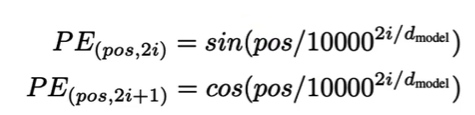

- pos: biểu diễn vị trí của từ trong câu
- i: biểu diễn index demension
- dmodel: biểu diễn độ dài của vector embedding từ

In [61]:
sequence_length = 10
embedding_dim = 6

In [62]:
# Khởi tạo ma trận positional encoding
pe = torch.zeros(sequence_length, embedding_dim)

In [63]:
pe.size()

torch.Size([10, 6])

In [64]:
for pos in range(sequence_length):
    for i in range(0, embedding_dim, 2):
        pe[pos, i] = math.sin(pos/(10000**(2*i/embedding_dim)))
        pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/embedding_dim)))

In [70]:
pe

tensor([[ 0.00e+00,  1.00e+00,  0.00e+00,  1.00e+00,  0.00e+00,  1.00e+00],
        [ 8.41e-01,  9.77e-01,  2.15e-03,  1.00e+00,  4.64e-06,  1.00e+00],
        [ 9.09e-01,  9.09e-01,  4.31e-03,  1.00e+00,  9.28e-06,  1.00e+00],
        [ 1.41e-01,  7.98e-01,  6.46e-03,  1.00e+00,  1.39e-05,  1.00e+00],
        [-7.57e-01,  6.51e-01,  8.62e-03,  1.00e+00,  1.86e-05,  1.00e+00],
        [-9.59e-01,  4.74e-01,  1.08e-02,  1.00e+00,  2.32e-05,  1.00e+00],
        [-2.79e-01,  2.75e-01,  1.29e-02,  1.00e+00,  2.78e-05,  1.00e+00],
        [ 6.57e-01,  6.27e-02,  1.51e-02,  1.00e+00,  3.25e-05,  1.00e+00],
        [ 9.89e-01, -1.52e-01,  1.72e-02,  1.00e+00,  3.71e-05,  1.00e+00],
        [ 4.12e-01, -3.60e-01,  1.94e-02,  1.00e+00,  4.18e-05,  1.00e+00]])

# 4. Layer Normalization

# 5. Transformer encoder

In [2]:
d_model = 512
n_heads = 8
dropout = 0.1
batch_size = 10
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5